In [1]:
import numbers
from collections import Counter
from scipy.stats import mode
from sklearn.utils import _safe_indexing
from sklearn.utils._param_validation import HasMethods, Interval, StrOptions
import pandas as pd
import numpy as np
import seaborn as sns    
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import (f1_score, roc_auc_score, average_precision_score, 
                             accuracy_score, matthews_corrcoef, recall_score, 
                             precision_score, confusion_matrix)

In [2]:
df = pd.read_csv('C:/Users/asus pc/OneDrive/Desktop/Nikbakht/imputed_Extra_tree .csv')
df = df.drop('ID' ,axis = 1)

In [3]:
X=df.drop('Hospital_outcome',axis=1)
y=df['Hospital_outcome']

In [4]:
categorical_features = ['Sex','Digestive_underlying', 'Respiratory_underlying','Infectious_underlying','Fatness_underlying', 'Urinary_underlying',
'Diabete_underlying', 'Highbloodpressure_underlying','Heart_underlying','Nervous_underlying', 'Blooddisease_underlying','Opiate', 'Education', 
'Urinary', 'Urinary_Incontinence', 'Previous_recurrent', 'Noconsious', 'GCS','Receivingblood', 'Conciousness', 'Patient_arrival', 'Time',
'Type_stroke', 'Treatment_method', 'Pneumonia', 'Convulsions','Individual', 'Motionless','Respiratory', 'Heart', 'Edema', 'Bloody',
'Vision_impairment', 'Sensory', 'Headache', 'Blurred_Vision','Reduce_strength_limb', 'Lackofbalance', 'Weakness', 'Delirium','Skin_problems',
'Aphasia_and_Dysarthria', 'Cranial_nerve_Disorder','Paralyzed', 'Digestive_problems']  # Replace with your categorical column names
numeric_features = ['Age','RR','HR','systolic','Lengthofhospitalization']
df[categorical_features] = df[categorical_features].astype('category')

In [5]:
# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=101
)

# OneHotEncoder

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])

In [7]:
from sklearn.ensemble import IsolationForest
# Outlier detection (on training data only)
outlier_detector = IsolationForest(contamination=0.05, random_state=101)
outliers = outlier_detector.fit_predict(preprocessor.fit_transform(X_train))
inlier_mask = outliers != -1

In [8]:
# Apply outlier removal
X_train_clean, y_train_clean = X_train.iloc[inlier_mask], y_train.iloc[inlier_mask]

In [9]:
# Preprocess cleaned training data
X_train_preprocessed = preprocessor.transform(X_train_clean)

In [11]:
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.model_selection import train_test_split
# Initialize SMOTEENN (which combines SMOTE oversampling with ENN cleaning)
smote_enn = SMOTEENN(random_state=101)
X_train_res, y_train_res = smote_enn.fit_resample(X_train_preprocessed, y_train_clean)

In [12]:
print("Class distribution before ENN-SMOTE:", Counter(y_train))
print("Class distribution after ENN-SMOTE:", Counter(y_train_res))

Class distribution before ENN-SMOTE: Counter({0: 1605, 1: 315})
Class distribution after ENN-SMOTE: Counter({1: 1547, 0: 1058})


# Create DNN-ENN_SMOTE Model

In [13]:
class MyClassifier(KerasClassifier):
    def __sklearn_tags__(self):
        return {"estimator_type": "classifier"}


In [14]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Reshape
def create_model(activation='relu'):
    model = Sequential([
        Reshape((X_train_res.shape[1],), input_shape=(X_train_res.shape[1],)),  # Explicit reshape
        Dense(64, activation=activation),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap model with KerasClassifier
model = KerasClassifier(model=create_model, activation='relu', random_state=101)

# Define parameter grid
param_grid = {
    'activation': ['relu', 'tanh', 'sigmoid'],  # Activation function options
    'batch_size': [16, 32, 64],  # Batch size options
    'epochs': [50, 100]  # Number of epochs
}

# Perform Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1,verbose=1)
dnn_model = grid.fit(X_train_res, y_train_res)

# Display best parameters
print("Best Parameters:", dnn_model.best_params_)
print("Best Score:", dnn_model.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7977 - loss: 0.4199
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9007 - loss: 0.2440
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9123 - loss: 0.2075
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9244 - loss: 0.1760
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9437 - loss: 0.1456
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9554 - loss: 0.1193
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9681 - loss: 0.0957
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9765 - loss: 0.0740
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9849 - loss: 0.0569
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0438
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

In [15]:
dnn_model = KerasClassifier(
    model=create_model,
    activation='relu',      # From best params
    batch_size=16,            # From best params  
    epochs=100, random_state=101               # From best params
)
dnn_model = dnn_model.fit(X_train_res, y_train_res)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7977 - loss: 0.4199
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9007 - loss: 0.2440
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9123 - loss: 0.2075
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9244 - loss: 0.1760
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9437 - loss: 0.1456
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9554 - loss: 0.1193
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9681 - loss: 0.0957
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9765 - loss: 0.0740
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0569
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.0438
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9920 - loss: 0.0331
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━

In [16]:
# Evaluate on test set
X_test_preprocessed = preprocessor.transform(X_test)

In [17]:
# Train the final model with the best parameters
y_pred = dnn_model.predict(X_test_preprocessed)
dnn_probs = dnn_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [18]:
# Evaluate best model REEN
accuracy = accuracy_score(y_test, y_pred)
print("\nOptimized Test Accuracy:",accuracy)


Optimized Test Accuracy: 0.7985436893203883


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [20]:
# Convert confusion matrix to percentages
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100

In [21]:
# Print confusion matrix (counts)
print("Confusion Matrix (Counts):")
print(cm)

Confusion Matrix (Counts):
[[549 140]
 [ 26 109]]


In [22]:
# Print confusion matrix (percentages)
print("\nConfusion Matrix (Percentages):")
print(cm_percent)


Confusion Matrix (Percentages):
[[79.68069666 20.31930334]
 [19.25925926 80.74074074]]


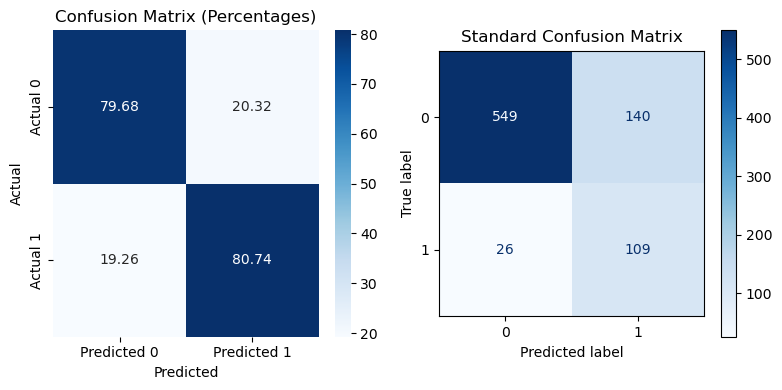

In [23]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# First plot: Percentage confusion matrix (Seaborn)
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix (Percentages)')

# Second plot: Standard confusion matrix (Scikit-learn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=dnn_model.classes_)
disp.plot(cmap='Blues', ax=ax2)
ax2.set_title('Standard Confusion Matrix')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [24]:
# Calculate and print the error rate and the number of misclassifications
err = 1 - accuracy_score(y_test, y_pred)
n_miss = np.sum(y_pred != y_test)
print(f"Error Rate: {err}")
print(f"Number of Misclassifications: {n_miss}")

Error Rate: 0.20145631067961167
Number of Misclassifications: 166


In [25]:
from sklearn.metrics import classification_report
# Generate classification report 
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       689
           1       0.44      0.81      0.57       135

    accuracy                           0.80       824
   macro avg       0.70      0.80      0.72       824
weighted avg       0.87      0.80      0.82       824



In [26]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import matthews_corrcoef
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = np.sqrt(sensitivity * specificity)
f1_score = f1_score(y_test, y_pred)
# Print results
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"G-mean: {g_mean:.3f}")
print(f"F1_measure: {f1_score:.3f}")
print(f"MCC: {mcc:.3f}")

Sensitivity (Recall): 0.807
Specificity: 0.797
G-mean: 0.802
F1_measure: 0.568
MCC: 0.487


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


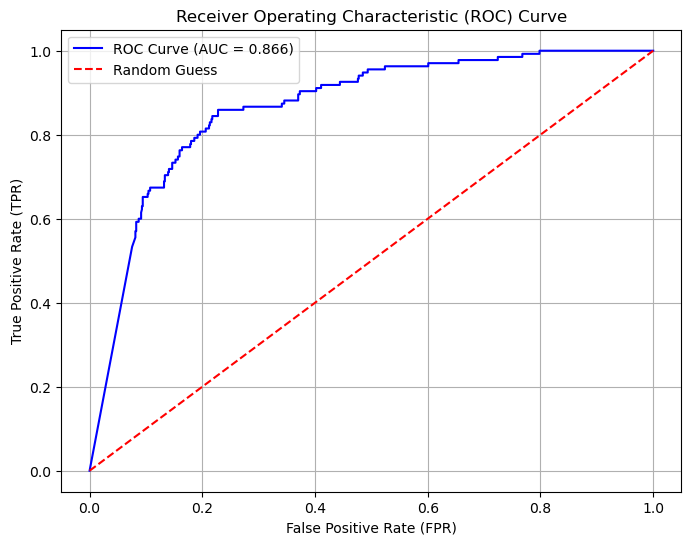

AUCROC: 0.866


In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
# Get predicted probabilities for positive class
dnn_probs = dnn_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)
fpr, tpr, thresholds = roc_curve(y_test, dnn_probs, pos_label=dnn_model.classes_[1])
# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, dnn_probs)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the AUC score
print(f'AUCROC: {auc:.3f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


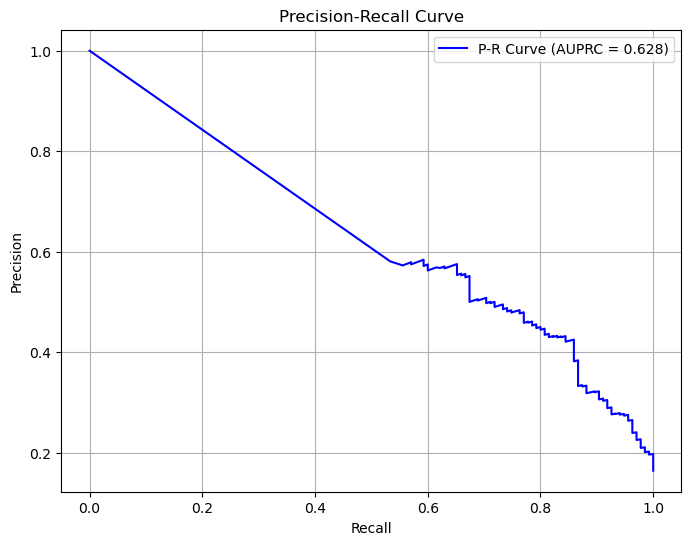

AUPRC: 0.628


In [28]:
from sklearn.metrics import precision_recall_curve, auc
# Get predicted probabilities for the positive class
dnn_probs = dnn_model.predict_proba(X_test_preprocessed)[:, 1]   # For scikit-learn models
# For Keras: y_probs = model.predict(X_test).flatten()
# Calculate P-R curve
precision, recall, thresholds = precision_recall_curve(y_test, dnn_probs)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'P-R Curve (AUPRC = {pr_auc:.3f})',color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the pr-auc score
print(f'AUPRC: {pr_auc:.3f}')

In [13]:
#DNN
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Reshape
def create_model(activation='relu'):
    model = Sequential([
        Reshape((X_train_resampled.shape[1],), input_shape=(X_train_resampled.shape[1],)),  # Explicit reshape
        Dense(64, activation=activation),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
dnn_model = KerasClassifier(
    model=create_model,
    activation='relu',      # From best params
    batch_size=16,            # From best params  
    epochs=50,random_state=101               # From best params
)

In [14]:
###RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Initialize Random Forest
rf_model = RandomForestClassifier(bootstrap= False,max_depth= 20,max_features= 'log2',min_samples_split=2,min_samples_leaf=1,
                                  n_estimators= 200,oob_score =False,random_state=101)

In [15]:
#XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
xgb_model = XGBClassifier(use_label_encoder=True, eval_metric='logloss',colsample_bytree=0.6,gamma=0,
learning_rate=0.1,max_depth=7, min_child_weight=1,n_estimators=100,subsample =0.8,random_state=101)

In [16]:
#SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
svm_model = SVC(C=1,
    kernel='rbf',
    degree=1,
    gamma='scale',probability=True, random_state=101) 

In [17]:
# Initialize models
models = {
    "DNN": dnn_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "SVC" : svm_model
}

In [18]:
def g_mean(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    return np.sqrt(specificity * sensitivity)

In [19]:
# Results storage
results = []
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': name,
        'Type': 'smote',
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'G-Mean': g_mean(y_test, y_pred),
        'AUROC': roc_auc_score(y_test, y_prob),
        'AUPRC': average_precision_score(y_test, y_prob),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }
    results.append(metrics)
    
    # Print formatted metrics (3 decimal places)
    print(
        f"{name}: "
        f"Accuracy = {metrics['Accuracy']:.3f}, "
        f"F1 = {metrics['F1']:.3f}, "
        f"G-Mean = {metrics['G-Mean']:.3f}, "
        f"AUROC = {metrics['AUROC']:.3f}, "
        f"AUPRC = {metrics['AUPRC']:.3f}, "
        f"MCC = {metrics['MCC']:.3f}"
    )

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7574 - loss: 0.5102
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.3182
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8832 - loss: 0.2661
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9011 - loss: 0.2356
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9119 - loss: 0.2154
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9189 - loss: 0.1992
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9259 - loss: 0.1846
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9297 - loss: 0.1693
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9345 - loss: 0.1569
Epoch 10/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9409 - loss: 0.1438
Epoch 11/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9474 - loss: 0.1330
Epoch 12/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step